# The Entire Intent of Query Model

## About Elmo
#### ELMo is created by AllenNLP which unlike Glove, Fasttext, Word2Vec, etc. provides the contextualized word embeddings whose vector representation for a word differs in a sentence to sentence.

## Why?

####  if a query is given like ‘Apple Juice’ the embedding generated for the token ‘apple’ here will be different from the one in ‘Apple Laptop’. 

#### since LSTM network is being used internally in ELMo model, we need not to bother about the word that is not present in the dictionary of the training dataset as it generates the character embedding as well
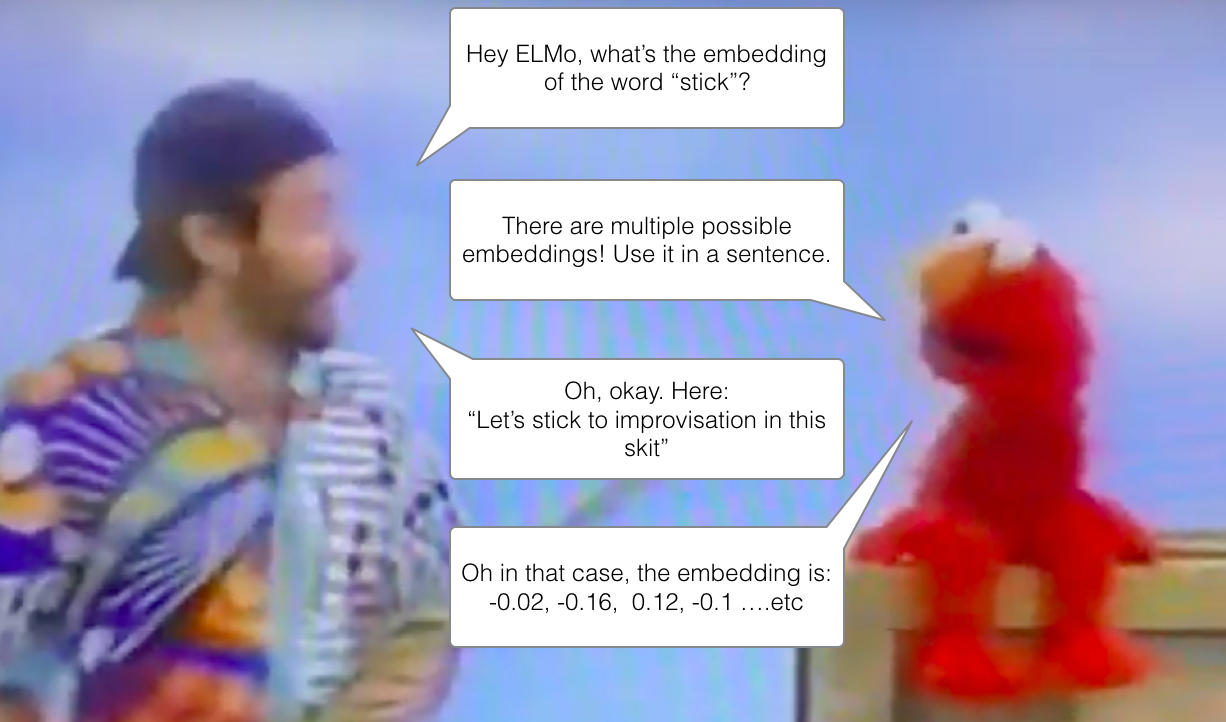

### Download Elmo

## TF Hub https://tfhub.dev/

### TensorFlow Hub is a platform to publish, discover, and reuse parts of machine learning modules in TensorFlow. By a module, it means a self-contained piece of a TensorFlow graph, along with its weights, that can be reused across other, similar tasks. 

### By reusing a module, a developer can perform transfer learning. The pre-trained Elmo model is also present on Tensorflow Hub.

In [1]:
!mkdir /Users/sks000y/Desktop/DHS/elmo_module
!curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC /Users/sks000y/Desktop/DHS/elmo_module

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  331M    0 14959    0     0   5053      0 19:05:00  0:00:02 19:04:58 14059x assets/
x saved_model.pb
x tfhub_module.pb
x variables/
x variables/variables.index
100  331M  100  331M    0     0  6449k      0  0:00:52  0:00:52 --:--:-- 7548k



### Intializing Caching

In [2]:
from cachetools import TTLCache, cached
import tensorflow as tf
cache = TTLCache(maxsize=100, ttl=21600)

### Configuring TF Hub for Elmo

In [3]:
import tensorflow_hub as hub
elmo = hub.Module("/Users/sks000y/Desktop/DHS/elmo_module", trainable=False)
@cached(cache)
def ELMoEmbedding(x):
    return elmo(tf.reshape(tf.cast(x, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  
    sess.run(tf.tables_initializer())
    embed=sess.run(ELMoEmbedding(tf.constant(['onion 1kg fresh <pad> <pad> <pad> <pad> <pad>'])))
  
print(embed.shape)

(1, 8, 1024)


# Visualization

In [126]:
df1 = pd.read_csv("/Users/sks000y/Desktop/QuS/category/train_data_10k/all_train.csv")
#Dropping the rows having length greater than 8
idx=0
for terms in df1['term']:
    len_of_term = len(str(terms).split(" "))
    if len_of_term > 8:
        df1 = df1.drop(idx, axis=0)
    idx+=1
#droping rows having term as NaN
print("Before: Size of df:"+str(len(df1)))
indx = list(df1[df1.term!=df1.term].index)
df1 = df1.drop(df1.index[indx])
print("After: Size of df:"+str(len(df1)))

#Maximum length of query present
max_len = max(len(word.split(" ")) for word in lst)
lst = [word + " <pad>" * (max_len- len(word.split(" "))) for word in lst]
print("Maximum length of query present:" + str(max_len))
sentences=df1['term'].tolist()

Before: Size of df:9978
After: Size of df:9970
Maximum length of query present:8


In [125]:
import numpy as np
fin = np.load("/Users/sks000y/Downloads/elmo1.npz")
fin = fin['name1']
from sklearn.decomposition import PCA
pca = PCA(n_components=50) #reduce down to 50 dim
y = pca.fit_transform(fin.reshape(9970,-1))
from sklearn.manifold import TSNE
y = TSNE(n_components=2).fit_transform(y) # further reduce to 2 dim using t-SNE

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
data = [
    go.Scatter(
        x=[i[0] for i in y],
        y=[i[1] for i in y],
        mode='markers',
        text=[i for i in sentences],
    marker=dict(
        size=16,
        color = [len(i) for i in sentences], #set color equal to a variable
        opacity= 0.8,
        colorscale='Viridis',
        showscale=False
    )
    )
]
layout = go.Layout()
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
fig = go.Figure(data=data, layout=layout)
file = plot(fig, filename='query_embed.html')

In [1]:
from IPython.display import IFrame

IFrame(src='./query_embed.html', width=1024, height=600)

## Keras Sequential vs Functional API

In [ ]:
#Don't Run (Prototype)
#Sequential 
first = Sequential()
first.add(Dense(1, input_shape=(2,), activation='sigmoid'))

second = Sequential()
second.add(Dense(1, input_shape=(1,), activation='sigmoid'))

merged = Concatenate([first, second])


#Functional 
#non-linear topology and models with multiple inputs or outputs.
first_dense = Dense(1, )(first_input)

second_dense = Dense(1, )(second_input)

merge_one = concatenate([first_dense, second_dense])

# Modeling

In [35]:
# Keras Functional API

from tensorflow.keras import layers
input_text = layers.Input(shape=(1,), dtype="string", name="Input_Query")
embedding = layers.Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_text)
x = layers.Bidirectional(layers.LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding)
x = layers.Dense(8336, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4168, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2083, activation='sigmoid')(x)

In [36]:
model = tf.keras.Model(inputs=[input_text], outputs=outputs, name="TEIOQ")
model.summary()

Model: "TEIOQ"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Query (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_3 (Dense)              (None, 8336)              17080464  
_________________________________________________________________
dropout_2 (Dropout)          (None, 8336)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4168)              34748616  
_________________________________________________________________
dropout_3 (Dropout)          (None, 4168)              0     

In [37]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Model Architecture

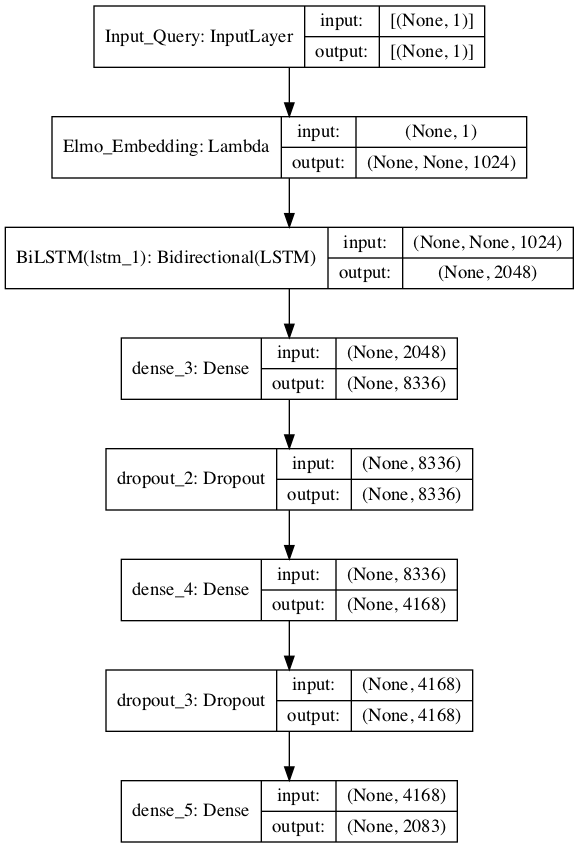

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training

In [98]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from os import path
from tensorflow.keras.callbacks import EarlyStopping
import gc
model_checkpoint = '/Users/sks000y/Desktop/DHS/model_chkpt/model.chkpt'

gc.collect() 
es = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=1)

tf_saver = tf.train.Saver()
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer()) 
    # Loading checkpoint if exists
    if path.isdir("/Users/sks000y/Desktop/DHS/model_chkpt/"):
      print("loading chkpt")
      tf_saver.restore(session, model_checkpoint)
    model.fit(train_text,y_train,batch_size=200,epochs=1, validation_split=0.25, callbacks=[es])
    tf_saver.save(session, model_checkpoint)
    predition = model.predict([["soya milk <pad> <pad> <pad> <pad> <pad> <pad>"]])
    tf.saved_model.simple_save(session, '/Users/sks000y/Desktop/DHS/teioq-model', inputs={"term": model.input}, outputs={",".join([x for x in df.columns[:-1]]):model.output})

loading chkpt
Train on 3750 samples, validate on 1250 samples


Exception ignored in: <function BaseSession._Callable.__del__ at 0x12df94268>
Traceback (most recent call last):
  File "/anaconda2/envs/oop_python3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


3600/3750 [===========================>..] - ETA: 2s - loss: 0.0247 - acc: 0.9979

Exception ignored in: <function BaseSession._Callable.__del__ at 0x12df94268>
Traceback (most recent call last):
  File "/anaconda2/envs/oop_python3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


3750/3750 [==============================] - 71s 19ms/sample - loss: 0.0242 - acc: 0.9979 - val_loss: 0.0119 - val_acc: 0.9982


Exception ignored in: <function BaseSession._Callable.__del__ at 0x12df94268>
Traceback (most recent call last):
  File "/anaconda2/envs/oop_python3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
W1007 14:18:48.234842 4717499840 deprecation.py:323] From <ipython-input-98-49352e5129e0>:23: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
W1007 14:18:48.235934 4717499840 deprecation.py:323] From /anaconda2/envs/oop_python3/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be rem

# Make it to Production

In [ ]:
from tensorflow.contrib import predictor
predict_fn = predictor.from_saved_model("/Users/sks000y/Desktop/DHS/teioq-model")
predictions = predict_fn(
    {"term":[["yorkshire puddings <pad> <pad> <pad> <pad> <pad> <pad>"]]})
print(predictions)
import numpy as np
z=np.array(list(predictions.values()))[0]